In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats import norm
import scipy
%matplotlib inline

In [2]:
# initializing all the variables
capacity = {'coach':100,'firstclass':20} # capacity of the flight in each of the ticket classes
overbook = {'coach':5,'firstclass':0} # over-booking policy in each of the ticket classes. 
bumpingcosts = {'tofirst':50, 'planeoff':425} # bumping costs 'tofirst' is airline cost of bumping a customer from coach
# to firstclass, 'planeoff' is airline_cost of bumping a customer off the plane.
ticketprice = {'coach':[300,350],'firstclass':[425,500]} # low and high ticketprice options for each of the ticket classes
sale_prob = {'coach':[0.65,0.3],'firstclass':[0.08,0.04]} # probabilities of sale for each of the classes
delta = 1/(1+0.17/365) # discount rate
T = 365 # time from start of sale of tickets to flight departure

# Strategy 1 - Estimating expected profit when we decide to have overbooking of 5 coach seats.

In [3]:
def optimize_profit(capacity,overbook,bumpingcosts,ticketprice,sale_prob,delta,T):
    
    scValues = np.arange(capacity['coach']+overbook['coach']+1) # all possible number of seats left in coach
    sfValues = np.arange(capacity['firstclass']+overbook['firstclass']+1) # all possible number of seats left in firstclass
    tValues = np.arange(T+1) # all possible days until takeoff
    scN = len(scValues)# count possible state values
    sfN = len(sfValues)# count possible state values
    tN = len(tValues)
    V = np.zeros((scN,tN,sfN)) # initialize value function
    U = np.zeros((scN,tN,sfN)) # initialize optimal choice variable
    
    LC_price = ticketprice['coach'][0] # lower choice of ticketprice of a coach ticket
    HC_price = ticketprice['coach'][1]  # higher choice of ticketprice of a coach ticket
    LF_price = ticketprice['firstclass'][0] # lower choice of ticketprice of a firstclass ticket
    HF_price = ticketprice['firstclass'][1] # higher choice of ticketprice of a firstclass ticket

    #demand prob
    pcL = [1-sale_prob['coach'][0],sale_prob['coach'][0]] # low ticket price coach 
    pcH = [1-sale_prob['coach'][1],sale_prob['coach'][1]] #  high ticket price coach 
    pfL = [1-sale_prob['firstclass'][0],sale_prob['firstclass'][0]] # low ticket price first class ticket
    pfH = [1-sale_prob['firstclass'][1],sale_prob['firstclass'][1]] #high ticket price first class ticket
    Coach_cap = capacity['coach'] # number of seats in coach
    First_cap = capacity['firstclass'] # number of seats in firstclass

    #boundary/terminal condition
    U[:,tN-1,:] = 33  # 1: lower ticket price, 2: higher ticket price, 3  value for no tickets for sale.
 
    # airline cost calculation for each of the scenarios of number of seats still available in coach and firstclass at the
    # time of takeoff.
    for sc in range(scN):
        tc = scN - sc-1 # number of coach tickets booked
        for sf in range(sfN):
            tf = sfN - sf-1 # number of firstclass tickets booked
            airline_cost = 0
            for tc_actual in range(tc+1): #looping possible no. of coach passengers actually coming for departure
                pr_tc_act = scipy.stats.binom.pmf(tc_actual,tc,0.95) #probability of actual no. of people coming for departure
                for tf_actual in range(tf+1): # looping possible no. of firstclass passengers actually coming for departure
                    pr_tf_act = scipy.stats.binom.pmf(tf_actual,tf,0.97) #probability of actual no. of people coming for departure
                    if tc_actual<=Coach_cap: # if no. of people coming < coach capacity
                        airline_cost = airline_cost+0
                    else:
                        if tc_actual-Coach_cap <= First_cap-tf_actual:# seats in first class > if number (coach passengers) showeing up > capacity(coach)
                        # airline cost = airline cost to bump to firstclass
                            airline_cost = airline_cost - pr_tc_act*pr_tf_act*bumpingcosts['tofirst']*(tc_actual-Coach_cap)
                        else:
                        # Costs include upgrading to first class until full, then offloading the rest, if coach arrivals exceed both coach and first-class capacities.
                            airline_cost = airline_cost - pr_tc_act*pr_tf_act*(bumpingcosts['tofirst']*(First_cap-tf_actual) 
                                                               + bumpingcosts['planeoff']*(tc_actual-Coach_cap-(First_cap-tf_actual)))
            V[sc,tN-1,sf] = airline_cost
        
        
    # using Bellman equation to calculate the expected Value backward in time for each of the scenarios    
    for t in reversed(range(tN-1)):
        for sc in range(scN):
            for sf in range(sfN):

                if sc==0 and sf==0: # is the flight full (0 seats left)
                    V[sc,t,sf]= delta*V[sc,t+1,sf] # if so, you can't make any more money
                    U[sc,t,sf]=33 # No tickets can be sold.

                elif sc !=0 and sf==0: # coach tickets available, no first class, increasing the probability of sale coach tickets by 0.03.
                    # value if coach ticket price low
                    CL_value = (pcL[1]+0.03)*LC_price + delta* ((pcL[0]-0.03)*V[sc,t+1,sf] + (pcL[1]+0.03)*V[sc-1,t+1,sf])
                    # value if you set the coach ticketprice high
                    CH_value = (pcH[1]+0.03)*HC_price + delta* ((pcH[0]-0.03)*V[sc,t+1,sf] + (pcH[1]+0.03)*V[sc-1,t+1,sf]) 

                    V[sc,t,sf]=max(CL_value,CH_value) # value function maximizes expected profit
                    U[sc,t,sf]=(np.argmax([CL_value,CH_value])+1)*10+3

                elif sc == 0 and sf!=0: # there are firstclass tickets available but not coach
                    # value if first class ticket price low
                    LF_value = (pfL[1])*LF_price + delta* ((pfL[0])*V[sc,t+1,sf] + (pfL[1])*V[sc,t+1,sf-1])
                    # value if you set the first class ticket price high
                    HF_value = (pfH[1])*HF_price + delta* ((pfH[0])*V[sc,t+1,sf] + (pfH[1])*V[sc,t+1,sf-1]) 

                    V[sc,t,sf]=max(LF_value,HF_value) # value function maximizes expected profit
                    U[sc,t,sf]=30+np.argmax([LF_value,HF_value])+1

                else:
                    # value if you set both coach and firstclass ticket prices low
                    LL_value = pcL[1]*LC_price + pfL[1]*LF_price + delta* (pfL[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticketprice low and firstclass ticketprice high
                    LH_value= pcL[1]*LC_price + pfH[1]*HF_price + delta* (pfH[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticketprice high and firstclass ticketprice low
                    HL_value = pcH[1]*HC_price + pfL[1]*LF_price + delta* (pfL[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcH[0]*V[sc,t+1,sf-1])

                    # value if you set both coach and firstclass ticket prices high
                    HH_value = pcH[1]*HC_price + pfH[1]*HF_price + delta* (pfH[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcH[0]*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(LL_value,LH_value,HL_value,HH_value) # value funciton maximizes expected profit 

                    U[sc,t,sf]=(int(np.argmax([LL_value,LH_value,HL_value,HH_value])/2)+1)*10\
                    +int((np.argmax([LL_value,LH_value,HL_value,HH_value])%2)!=0)+1
    return U,V

In [4]:
U1,V1 = optimize_profit(capacity,overbook,bumpingcosts,ticketprice,sale_prob,delta,T) # running the function for the policy of overbooking 5 coach ticket

V1[105,0,20] # expected profit if 5 seats to overbook in coach

41886.15862419589

In [5]:
z, x, y = U1.nonzero()

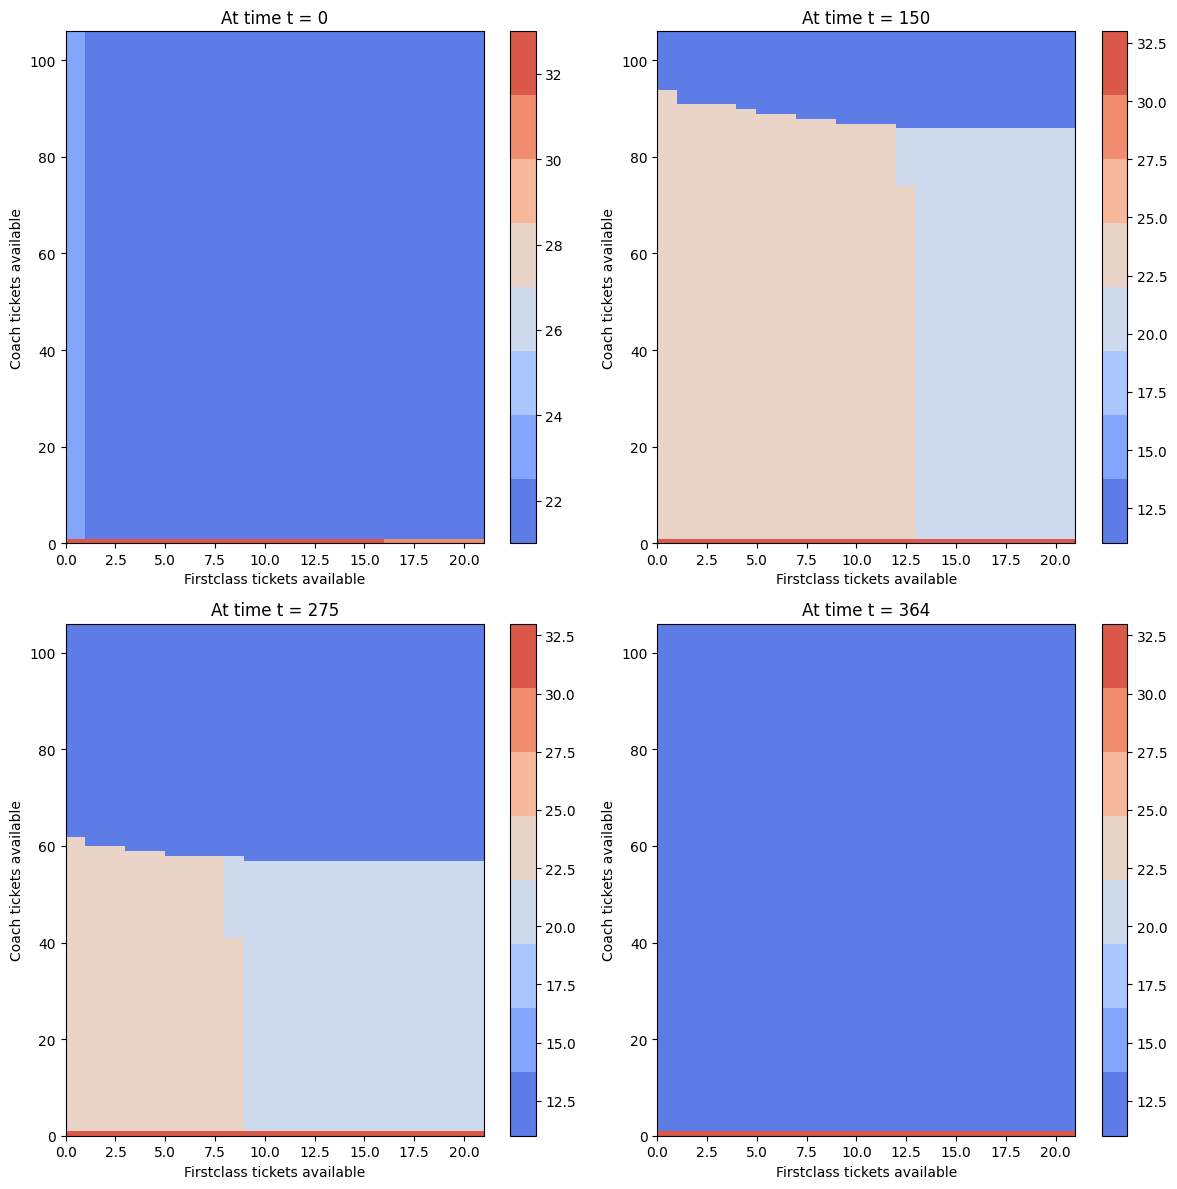

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

# Define the colormap using seaborn's 'coolwarm' palette
cmap = ListedColormap(sns.color_palette('coolwarm', 8).as_hex())

# Create the subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Specify the times to be plotted
times = [0, 100, 200, 364]
titles = ['At time t = 0', 'At time t = 150', 'At time t = 275', 'At time t = 364']

# Plot each subplot
for ax, time, title in zip(axs.flat, times, titles):
    c = ax.pcolor(U1[:, time, :], cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel('Firstclass tickets available')
    ax.set_ylabel('Coach tickets available')
    fig.colorbar(c, ax=ax)  # Add a colorbar to each subplot for clarity

# Adjust layout to make room for subplot titles and labels
plt.tight_layout()
plt.show()

# Estimating expected profits for overbooking 5-15 coach tickets

In [7]:
import pandas as pd

overbookext = [i for i in range(5, 16)]
profitinc = {}

for ob in overbookext:
    overbook = {'coach': ob, 'firstclass': 0}
    U, V = optimize_profit(capacity, overbook, bumpingcosts, ticketprice, sale_prob, delta, T)
    profit = V[capacity['coach'] + overbook['coach'], 0, capacity['firstclass'] + overbook['firstclass']]
    profitinc[ob] = profit

# Convert profitinc to a pandas DataFrame
df_profitinc = pd.DataFrame(list(profitinc.items()), columns=['Overbooking Extension', 'Profit Increase'])

# Round the 'Profit Increase' column to 2 decimal places
df_profitinc['Profit Increase'] = df_profitinc['Profit Increase'].round(2)

# Display the DataFrame
print(df_profitinc)

    Overbooking Extension  Profit Increase
0                       5         41886.16
1                       6         42011.22
2                       7         42085.54
3                       8         42122.17
4                       9         42134.62
5                      10         42132.90
6                      11         42123.67
7                      12         42111.03
8                      13         42097.42
9                      14         42084.11
10                     15         42071.74


the estimated profits also show that 9 overbooked tickets give maximum profits

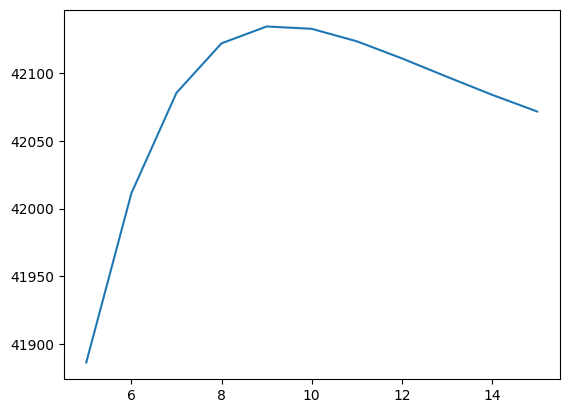

In [8]:
plt.plot(profitinc.keys(),profitinc.values())

Observed - selling 9 overbooked tickets would give the most expected profits

# Strategy2

In [9]:
def optimize_profit2(capacity,overbook,bumpingcosts,ticketprice,sale_prob,delta,T):
    
    scValues = np.arange(capacity['coach']+overbook['coach']+1) # all possible number of seats left in coach
    sfValues = np.arange(capacity['firstclass']+overbook['firstclass']+1) # all possible number of seats left in firstclass
    tValues = np.arange(T+1) # all possible days until takeoff
    scN = len(scValues)# count possible state values
    sfN = len(sfValues)# count possible state values
    tN = len(tValues)
    V = np.zeros((scN,tN,sfN)) # initialize value function
    U = np.zeros((scN,tN,sfN)) # initialize optimal choice variable
    
    LC_price = ticketprice['coach'][0] # lower choice coach ticket
    HC_price = ticketprice['coach'][1]  # higher choice coach ticket
    LF_price = ticketprice['firstclass'][0] # lower choice first class ticket
    HF_price = ticketprice['firstclass'][1] # higher choice first class ticket

    #demand probabilities
    pcL = [1-sale_prob['coach'][0],sale_prob['coach'][0]] # low ticket price coach
    pcH = [1-sale_prob['coach'][1],sale_prob['coach'][1]] # high ticket price coach
    pfL = [1-sale_prob['firstclass'][0],sale_prob['firstclass'][0]] # low ticket price first class
    pfH = [1-sale_prob['firstclass'][1],sale_prob['firstclass'][1]] # high ticket price first class
    Coach_cap = capacity['coach'] # seats in coach
    First_cap = capacity['firstclass'] # in firstclass

    #boundary/terminal condition
    U[:,tN-1,:] = 33 # 1: lower ticket price,  2: higher ticket price,  3  value for no tickets for sale
    
    # calculation for  scenarios of number of seats still available in coach and firstclass at takeoff
    for sc in range(scN):
        tc = scN - sc-1 # coach tickets booked
        for sf in range(sfN):
            tf = sfN - sf-1 # first class tickets booked
            airline_cost = 0
            for tc_actual in range(tc+1):# looping possible no. of coach passengers actually coming for departure
                pr_tc_act = scipy.stats.binom.pmf(tc_actual,tc,0.95)# probability (actual number of people showing up)
      
                for tf_actual in range(tf+1):#looping possible no. of first class passengers actually coming for departure
                    pr_tf_act = scipy.stats.binom.pmf(tf_actual,tf,0.97)# probability (actual number of people showing up) 
    
                    if tc_actual<=Coach_cap:#no (people) who showed up is less than the capacity of coach
                        airline_cost = airline_cost+0
                    else:
                        if tc_actual-Coach_cap <= First_cap-tf_actual:# seats in first class > if number (coach passengers) showing up > capacity(coach)
                        # airline cost = airline cost to bump to firstclass
                            airline_cost = airline_cost - pr_tc_act*pr_tf_act*bumpingcosts['tofirst']*(tc_actual-Coach_cap)
                        else:
                        # Costs include upgrading to first class until full, then offloading the rest, if coach arrivals exceed both coach and first-class capacities.
                            airline_cost = airline_cost - pr_tc_act*pr_tf_act*(bumpingcosts['tofirst']*(First_cap-tf_actual) 
                                                               + bumpingcosts['planeoff']*(tc_actual-Coach_cap-(First_cap-tf_actual)))
            V[sc,tN-1,sf] = airline_cost
        
        
    # Bellman equation to calculate the expected Value backward in time for each of the scenarios    
    for t in reversed(range(tN-1)):
        for sc in range(scN):
            for sf in range(sfN):

                if sc==0 and sf==0: # is the flight full (0 seats left)
                    V[sc,t,sf]=delta*V[sc,t+1,sf] # if so, you can't make any more money
                    U[sc,t,sf]=33 # (coach,firstclass)

                #coach tickets available but not first class, inc. probability of sale coach tickets by 0.03
                elif sc !=0 and sf==0:
                    # value if you set the coach ticketprice low
                    CL_value = (pcL[1]+0.03)*LC_price + delta* ((pcL[0]-0.03)*V[sc,t+1,sf] + (pcL[1]+0.03)*V[sc-1,t+1,sf])
                    # value if you set the coach ticketprice high
                    CH_value = (pcH[1]+0.03)*HC_price + delta* ((pcH[0]-0.03)*V[sc,t+1,sf] + (pcH[1]+0.03)*V[sc-1,t+1,sf]) 
                    # value if you decide not to sell the coach ticket
                    nocoach = 0 + delta*V[sc,t+1,sf] 

                    V[sc,t,sf]=max(CL_value,CH_value,nocoach) # value function maximizes expected profit
                    U[sc,t,sf]=(np.argmax([CL_value,CH_value,nocoach])+1)*10+3

                elif sc == 0 and sf!=0:# there are firstclass tickets available but not coach
                    # value if you set the firstclass ticketprice low
                    LF_value = (pfL[1])*LF_price + delta* ((pfL[0])*V[sc,t+1,sf] + (pfL[1])*V[sc,t+1,sf-1])
                    # value if you set the firstclass ticketprice high
                    HF_value = (pfH[1])*HF_price + delta* ((pfH[0])*V[sc,t+1,sf] + (pfH[1])*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(LF_value,HF_value) # value function maximizes expected revenue
                    U[sc,t,sf]=30+np.argmax([LF_value,HF_value])+1

                else:
                    # value if you decide not to sell coach and set firstclass ticketprice low
                    nocoach_low = pfL[1]*LF_price + delta* (pfL[0]*V[sc,t+1,sf]+pfL[1]*V[sc,t+1,sf-1])

                    # value if you decide not to sell coach and set firstclass ticketprice high
                    nocoach_high = pfH[1]*HF_price + delta* (pfH[0]*V[sc,t+1,sf]+pfH[1]*V[sc,t+1,sf-1])

                    # value if you set both coach and firstclass ticket prices low
                    LL_value = pcL[1]*LC_price + pfL[1]*LF_price + delta* (pfL[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcL[0]*V[sc,t+1,sf-1])
                    
                    # value if you set coach ticket price low and firstclass ticketprice high
                    LH_value= pcL[1]*LC_price + pfH[1]*HF_price + delta* (pfH[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticket price high and firstclass ticketprice low
                    HL_value = pcH[1]*HC_price + pfL[1]*LF_price + delta* (pfL[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcH[0]*V[sc,t+1,sf-1])
                    
                    # value if you set both coach and first class ticket price high
                    HH_value = pcH[1]*HC_price + pfH[1]*HF_price + delta* (pfH[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcH[0]*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(LL_value,LH_value,HL_value,HH_value,nocoach_low,nocoach_high) # value funciton maximizes expected profit 

                    U[sc,t,sf]=(int(np.argmax([LL_value,LH_value,HL_value,HH_value,nocoach_low,nocoach_high])/2)+1)*10\
                    +int((np.argmax([LL_value,LH_value,HL_value,HH_value,nocoach_low,nocoach_high])%2)!=0)+1
    return U,V

In [10]:
mod_overbook = {'coach':20,'firstclass':0}
U2,V2 = optimize_profit2(capacity,mod_overbook,bumpingcosts,ticketprice,sale_prob,delta,T)
V2[120,0,20]

42139.892762319796

# Expected profits overbooking 5-20 coach tickets

In [11]:
import pandas as pd

mod_overbookext = [i for i in range(5, 21)]
mod_profitinc = {}

for ob in mod_overbookext:
    mod_overbook = {'coach': ob, 'firstclass': 0}
    U2, V2 = optimize_profit2(capacity, mod_overbook, bumpingcosts, ticketprice, sale_prob, delta, T)
    profit = V2[capacity['coach'] + mod_overbook['coach'], 0, capacity['firstclass'] + mod_overbook['firstclass']]
    mod_profitinc[ob] = profit

# Convert mod_profitinc to a pandas DataFrame
df_mod_profitinc = pd.DataFrame(list(mod_profitinc.items()), columns=['Overbooking Extension', 'Profit Increase'])

# Round the 'Profit Increase' column to 2 decimal places
df_mod_profitinc['Profit Increase'] = df_mod_profitinc['Profit Increase'].round(2)

# Display the DataFrame
print(df_mod_profitinc)

    Overbooking Extension  Profit Increase
0                       5         41886.16
1                       6         42011.22
2                       7         42085.54
3                       8         42122.17
4                       9         42134.62
5                      10         42138.14
6                      11         42139.33
7                      12         42139.71
8                      13         42139.83
9                      14         42139.87
10                     15         42139.89
11                     16         42139.89
12                     17         42139.89
13                     18         42139.89
14                     19         42139.89
15                     20         42139.89


Noticed here that after 15 tickets, not getting any more profit (42139.89 rounded)

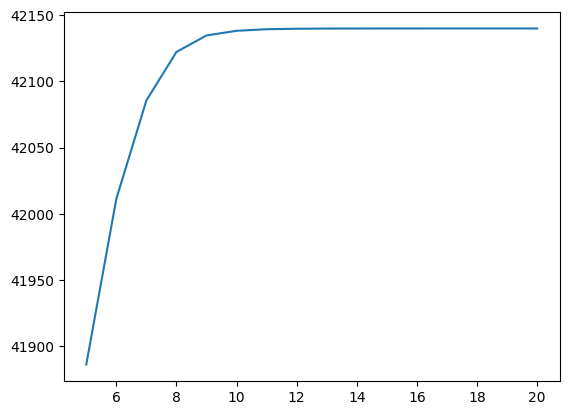

In [12]:
plt.plot(mod_profitinc.keys(),mod_profitinc.values())

noticed - after around 10 tickets, it could be decided to stop overbooking tickets to maximize profits.

# Comparison of Strategies

In [13]:
def simulate_profit(U,V,overbook):
    sc = 100 + overbook # on the first day all seats (capacity+overbook) are available in coach
    sf = 20 # on the first day all seats are available in firstclass
    tN = 366 # 0-365 is 366 values
    totalcoachrev = 0 # not made any money from coach ticket sales yet
    totalfirstrev = 0 # not made any money from first class ticket sales yet
    coachseats_left_vec = np.zeros(tN-1) # seats left in coach(capacity+overbook) after each time t
    firstseats_left_vec = np.zeros(tN-1) # seats left in first class after each time t
    coachdisrev_vec = np.zeros(tN-1) # discounted revenue generated after each time t from coach sales
    firstdisrev_vec = np.zeros(tN-1) # discounted revenue generated after each time t from first class sales
    coachprice_vec = np.zeros(tN-1) # ticketprice decided for coach sales at each time t
    firstprice_vec = np.zeros(tN-1) # ticketprice decided for firstclass sales at each time t
    
    for t in range(tN-1): # loop forward in time, don't need last time period since we can't sell anything then
        
        coach_charge = int(U[sc,t,sf]/10) # charge for coach ticket
        first_charge = int(U[sc,t,sf]/10) # charge for first class ticket
        coachprice_vec[t] = coach_charge
        firstprice_vec[t] = first_charge

        if coach_charge != 3 and first_charge != 3: # if both coach and first class tickets are being sold

            coach_actual_price = ticketprice['coach'][coach_charge-1]
            first_actual_price = ticketprice['firstclass'][first_charge-1]
            coach_sale_prob = sale_prob['coach'][coach_charge-1]
            first_sale_prob = sale_prob['firstclass'][first_charge-1]

        elif coach_charge == 3 and first_charge != 3: # if only first class tickets are being sold
            coach_actual_price = 0
            first_actual_price = ticketprice['firstclass'][first_charge-1]
            coach_sale_prob = 0
            first_sale_prob = sale_prob['firstclass'][first_charge-1]

        elif coach_charge != 3 and first_charge == 3: # if only coach tickets are being sold
            coach_actual_price = ticketprice['coach'][coach_charge-1]
            first_actual_price = 0
            coach_sale_prob = sale_prob['coach'][coach_charge-1]+0.03
            first_sale_prob = 0

        else: # no tickets for sale
            coach_actual_price = 0
            first_actual_price = 0
            coach_sale_prob = 0
            first_sale_prob = 0

        coach_sale = (np.random.random(1)<coach_sale_prob) # coach sale done or no
        first_sale = (np.random.random(1)<first_sale_prob) # first class sale done or no
        # when the flight is full, probability of sale is 0, we'll never get a sale
        sc = int(sc - coach_sale) # subtract whether or not a sale was made in coach
        sf = int(sf - first_sale) # subtract whether or not a sale was made in firstclass
        totalcoachrev = totalcoachrev + int(coach_sale)*coach_actual_price*(delta**(t)) # discounted rev from coach sales
        totalfirstrev = totalfirstrev + int(first_sale)*first_actual_price*(delta**(t)) # discounted rev from first class sales
 
        coachseats_left_vec[t] = sc
        firstseats_left_vec[t] = sf
        coachdisrev_vec[t] = totalcoachrev
        firstdisrev_vec[t] = totalfirstrev

    total_rev = totalcoachrev+totalfirstrev # total revenue generated
    tc = 100+overbook-sc # total number of coach tickets sold
    tf = 20-sf # total number of firstclass tickets sold
    tc_actual = (np.random.choice([1,0],tc,p=[0.95,0.05])).sum() # no. of coach people showed up for departure
    tf_actual = (np.random.choice([1,0],tf,p=[0.97,0.03])).sum() # no. of firstclass people showed up for departure
    if tc_actual < 100: # no. of coach people actually showing up for departure < capacity(coach)
        airline_cost = 0
    elif tc_actual-100 < 20-tf_actual: # vacancies in first class > no. of coach people actually showing up for departure > capacity(coach)
        airline_cost = bumpingcosts['tofirst']*(tc_actual-100)
    else: # no. coach people actually show up during departure > capacity(coach) + vacancies in first class
        airline_cost = bumpingcosts['tofirst']*(20-tf_actual)+bumpingcosts['planeoff']*((tc_actual-100)-(20-tf_actual))
    
    profit = total_rev - (delta**(tN-1))*airline_cost
    count_out = max(0,(tc_actual-100)-(20-tf_actual))
    
    return tc,tf,tc_actual,tf_actual,profit,count_out,airline_cost

## Strategy 1

In [14]:
overbook = {'coach':9,'firstclass':0}
U11,V11 = optimize_profit(capacity,overbook,bumpingcosts,ticketprice,sale_prob,delta,T)
V11[109,0,20]

42134.62483034169

In [65]:
nsim = 10000
profits_list = []
tc_actual_list = []
tf_actual_list = []
tc_list = []
tf_list = []
count_out_list = []
airline_cost_list = []

In [66]:
np.random.seed(15)
for sim in range(nsim):
    tc,tf,tc_actual, tf_actual,profit,count_out,airline_cost = simulate_profit(U11,V11,9)
    profits_list.append(profit)
    tc_list.append(tc)
    tf_list.append(tf)
    tc_actual_list.append(tc_actual)
    tf_actual_list.append(tf_actual)
    count_out_list.append(count_out)
    airline_cost_list.append(airline_cost)

/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = int(sc - coach_sale) # subtract whether or not a sale was made in coach
/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sf = int(sf - first_sale) # subtract whether or not a sale was made in firstclass
/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element 

In [67]:
print('Average discounted profit when decided to overbook 9 coach tickets:',np.array(profits_list).mean())
print('Standard deviation(discounted profit) when decided to overbook 9 coach tickets:',np.array(profits_list).std())

Average discounted profit when decided to overbook 9 coach tickets: 41054.53728977019
Standard deviation(discounted profit) when decided to overbook 9 coach tickets: 1470.1822881127064


## Strategy 2

In [68]:
mod_overbook = {'coach':20,'firstclass':0}
U22,V22 = optimize_profit2(capacity,mod_overbook,bumpingcosts,ticketprice,sale_prob,delta,T)
V22[120,0,20]

42139.892762319796

In [69]:
nsim = 10000
profits_list2 = []
tc_list2 = []
tf_list2 = []
tc_actual_list2 = []
tf_actual_list2 = []
count_out_list2 = []
airline_cost_list2 = []

In [70]:
np.random.seed(15)
for sim in range(nsim):
    tc,tf,tc_actual, tf_actual,profit,count_out,airline_cost = simulate_profit(U22,V22,20)
    profits_list2.append(profit)
    tc_list2.append(tc)
    tf_list2.append(tf)
    tc_actual_list2.append(tc_actual)
    tf_actual_list2.append(tf_actual)
    count_out_list2.append(count_out)
    airline_cost_list2.append(airline_cost)

/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = int(sc - coach_sale) # subtract whether or not a sale was made in coach
/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sf = int(sf - first_sale) # subtract whether or not a sale was made in firstclass
/var/folders/m5/m2tp6r3n4fj31mj_4qtr9vh40000gn/T/ipykernel_36854/2337589940.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element 

In [71]:
print('Average discounted profit when decided to overbook 20 coach tickets with not selling option:',np.array(profits_list2).mean())
print('Standard deviation (discounted profit) when decided to overbook 9 coach tickets:',np.array(profits_list2).std())

Average discounted profit when decided to overbook 20 coach tickets with not selling option: 41621.928998976735
Standard deviation (discounted profit) when decided to overbook 9 coach tickets: 1144.3949920814314


## Visualisations for strategy 1

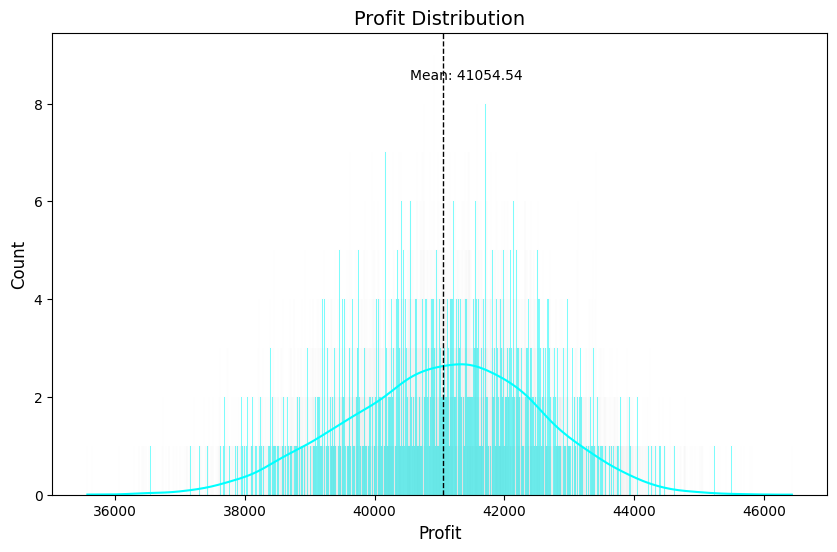

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert list to numpy array for better handling
data = np.array(profits_list)

# Set the size of the plot for better visibility
plt.figure(figsize=(10, 6))

# Create the histogram using seaborn's histplot, choosing green as the color
sns.histplot(data, kde=True, color="cyan", binwidth=1, binrange=(data.min(), data.max()))

# Calculate and draw the mean line
mean_value = data.mean()
plt.axvline(mean_value, color='k', linestyle='dashed', linewidth=1)

# Setting up annotations for the mean, adjusting position to the right
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {mean_value:.2f}', horizontalalignment='right')

# Setting titles and labels for clarity
plt.title('Profit Distribution', fontsize=14)
plt.xlabel('Profit', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

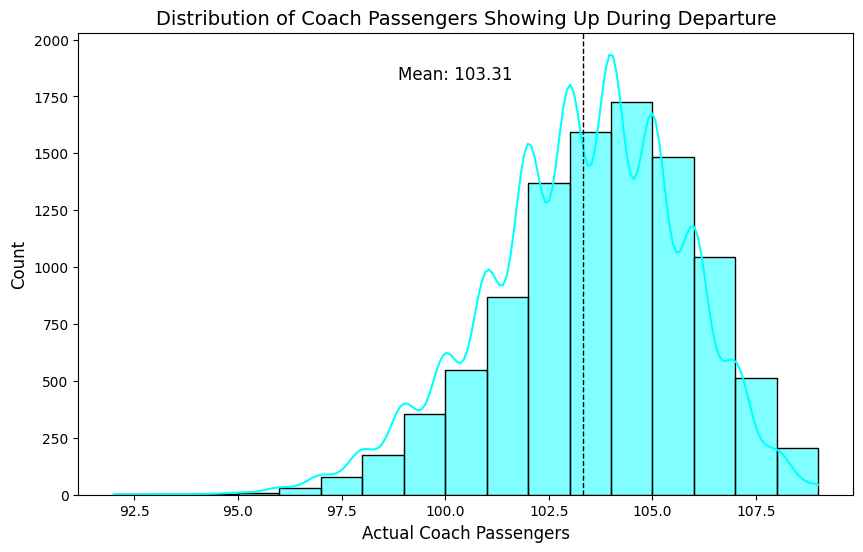

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert list to numpy array for calculations
tc_act_data = np.array(tc_actual_list)

plt.figure(figsize=(10, 6))
sns.histplot(tc_act_data, kde=True, color="cyan", binwidth=1, binrange=(tc_act_data.min(), tc_act_data.max()))
plt.axvline(tc_act_data.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {tc_act_data.mean():.2f}', fontsize=12)
plt.title('Distribution of Coach Passengers Showing Up During Departure', fontsize=14)
plt.xlabel('Actual Coach Passengers', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

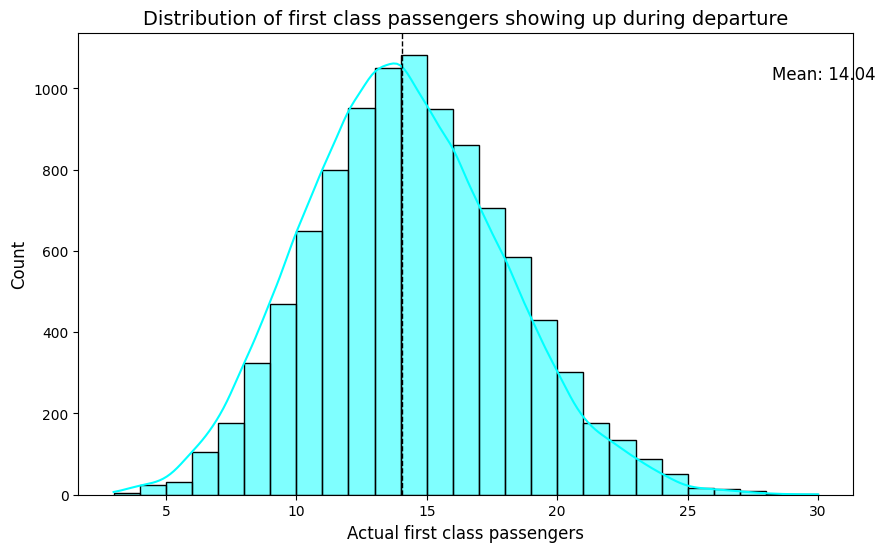

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert list to numpy array for better handling
tf_act_data = np.array(tf_actual_list)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the distplot with a histogram and a KDE
sns.histplot(tf_act_data, kde=True, color="cyan", binwidth=1, binrange=(tf_act_data.min(), tf_act_data.max()))

# Calculate and plot the mean line
mean_value = tf_act_data.mean()
plt.axvline(mean_value, color='k', linestyle='dashed', linewidth=1)

# Setting up annotations for the mean
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {mean_value:.2f}', fontsize=12)

# Setting titles and labels
plt.title('Distribution of first class passengers showing up during departure', fontsize=14)
plt.xlabel('Actual first class passengers', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()

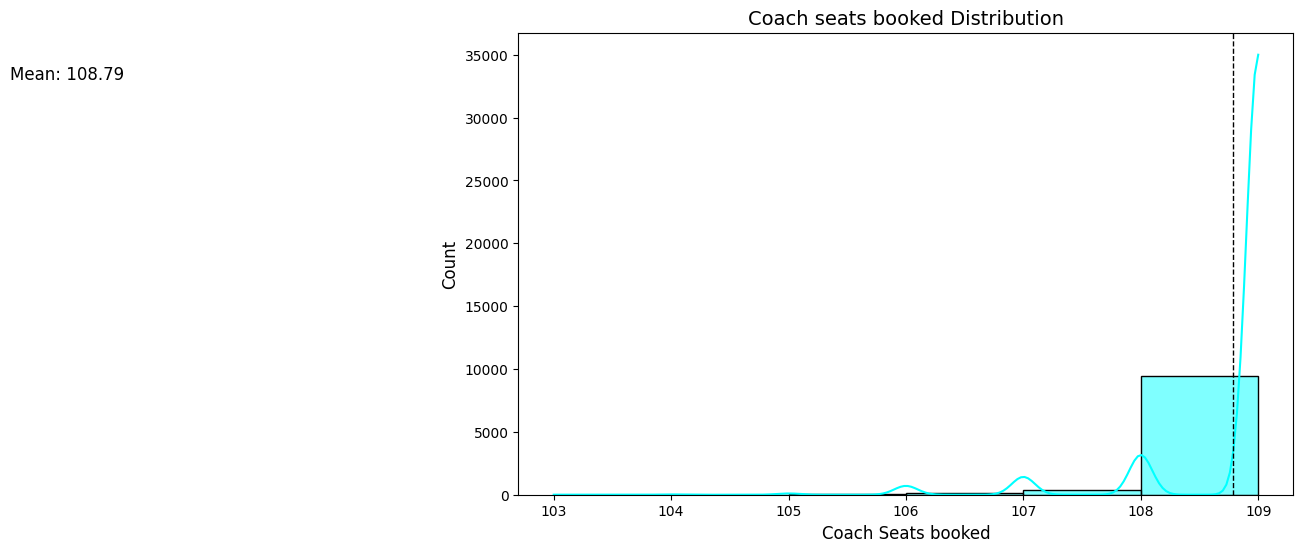

In [75]:
tc_data = np.array(tc_list)

plt.figure(figsize=(10, 6))
sns.histplot(tc_data, kde=True, color="cyan", binwidth=1, binrange=(tc_data.min(), tc_data.max()))
plt.axvline(tc_data.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {tc_data.mean():.2f}', fontsize=12)
plt.title('Coach seats booked Distribution', fontsize=14)
plt.xlabel('Coach Seats booked', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

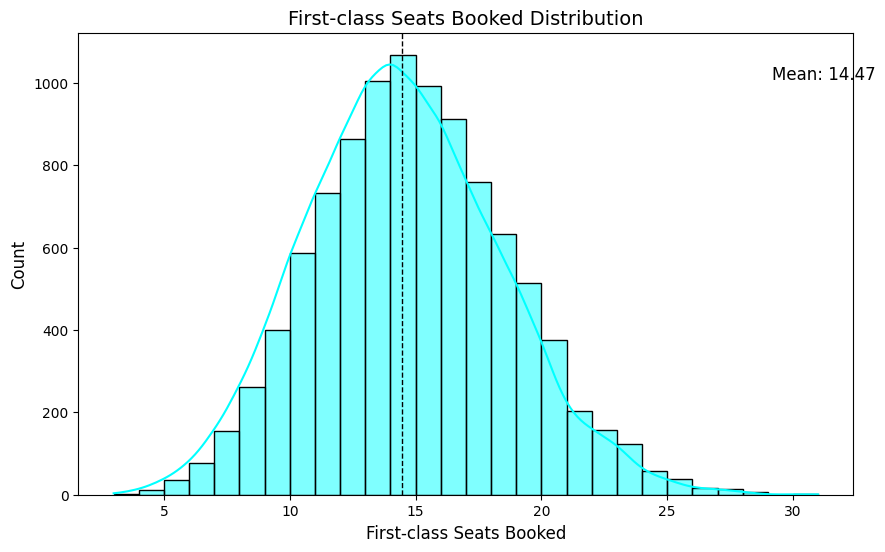

In [76]:
tf_data = np.array(tf_list)

plt.figure(figsize=(10, 6))
sns.histplot(tf_data, kde=True, color="cyan", binwidth=1, binrange=(tf_data.min(), tf_data.max()))
plt.axvline(tf_data.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {tf_data.mean():.2f}', fontsize=12)
plt.title('First-class Seats Booked Distribution', fontsize=14)
plt.xlabel('First-class Seats Booked', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

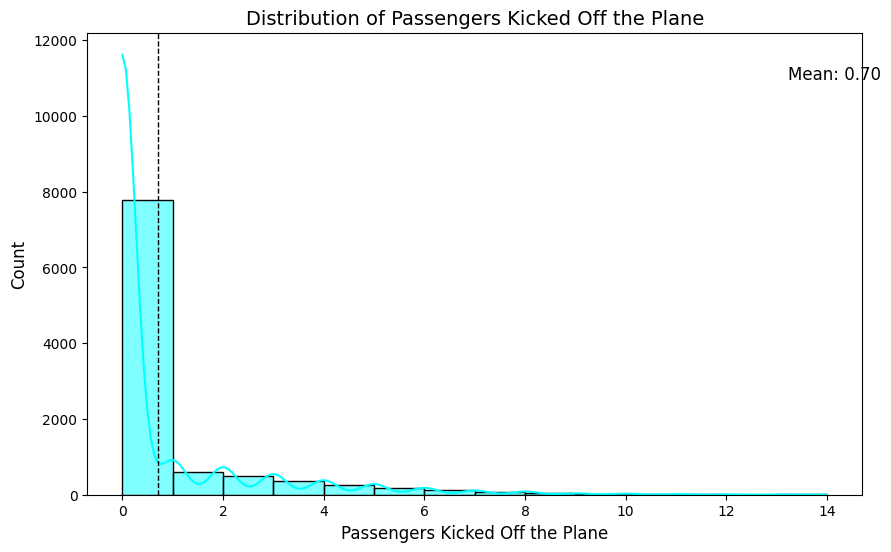

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = np.array(count_out_list)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color="cyan", binwidth=1, binrange=(data.min(), data.max()))
plt.axvline(data.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {data.mean():.2f}', fontsize=12)
plt.title('Distribution of Passengers Kicked Off the Plane', fontsize=14)
plt.xlabel('Passengers Kicked Off the Plane', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [78]:
no_passenger_kicked_count = count_out_list.count(0)
times_with_kickoffs = 10000 - count_out_list.count(0)

message = (
    f"Out of 10000 trials, there were {no_passenger_kicked_count} instances where no passenger was removed from the plane. "
    f"Whereas the occurrences where at least one passengergets removed are even more prevalent, amounting to {times_with_kickoffs}."
)

print(message)

Out of 10000 trials, there were 7778 instances where no passenger was removed from the plane. Whereas the occurrences where at least one passengergets removed are even more prevalent, amounting to 2222.


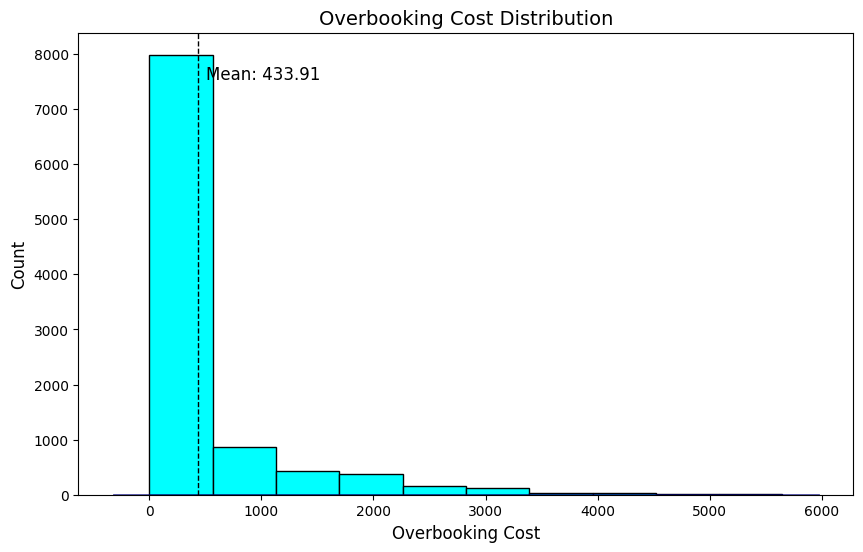

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = np.array(airline_cost_list)

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram using matplotlib's hist function with sky blue color
plt.hist(data, color='cyan', edgecolor='black')

# Overlay a density curve (kdeplot) with seaborn
sns.kdeplot(data, color="navy", linewidth=2, alpha=0.7)

# Draw a dashed vertical line at the mean
plt.axvline(data.mean(), color='k', linestyle='dashed', linewidth=1)

# Get the current limits of the plot for placing text and adjusting visuals
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()

# Place text annotation for the mean value, adjusting the position to be visible
plt.text(data.mean() + (max_xlim - min_xlim) * 0.01, max_ylim * 0.9, f'Mean: {data.mean():.2f}', fontsize=12)

# Set the title and labels with clear descriptions
plt.title('Overbooking Cost Distribution', fontsize=14)
plt.xlabel('Overbooking Cost', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()


## Visualizations for strategy 2

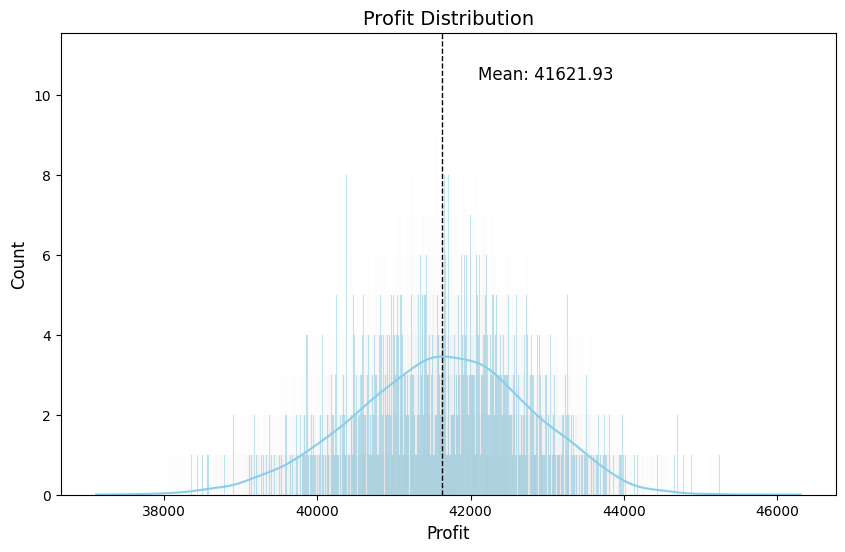

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert list to numpy array for calculations
profits_data2 = np.array(profits_list2)

plt.figure(figsize=(10, 6))
sns.histplot(profits_data2, kde=True, color="skyblue", binwidth=1, binrange=(profits_data2.min(), profits_data2.max()))
plt.axvline(profits_data2.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {profits_data2.mean():.2f}', fontsize=12)
plt.title('Profit Distribution', fontsize=14)
plt.xlabel('Profit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

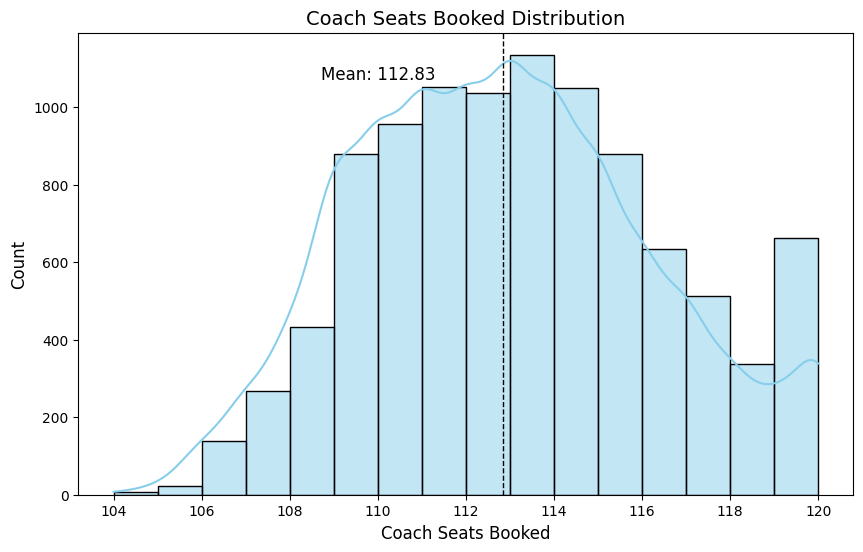

In [81]:
tc_data2 = np.array(tc_list2)

plt.figure(figsize=(10, 6))
sns.histplot(tc_data2, kde=True, color="skyblue", binwidth=1, binrange=(tc_data2.min(), tc_data2.max()))
plt.axvline(tc_data2.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, 'Mean: {:.2f}'.format(tc_data2.mean()), fontsize=12)
plt.title('Coach Seats Booked Distribution', fontsize=14)
plt.xlabel('Coach Seats Booked', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

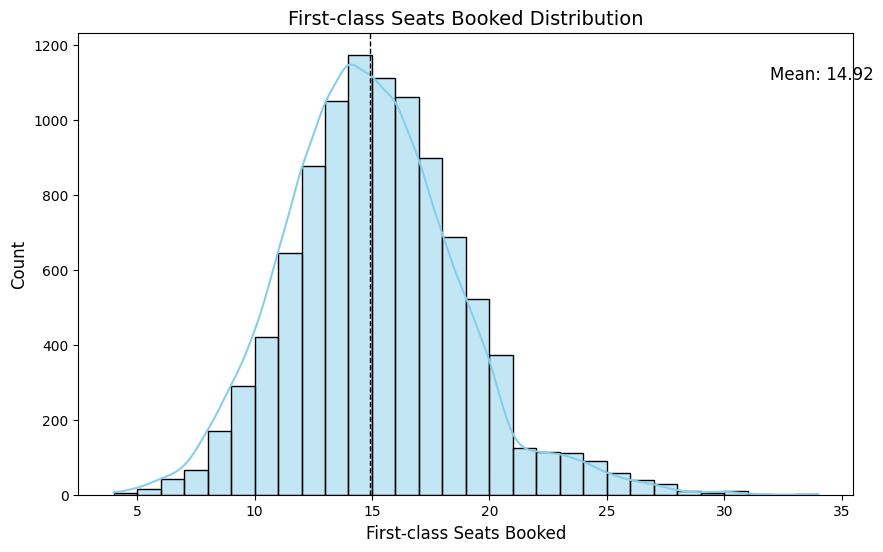

In [82]:
tf_data2 = np.array(tf_list2)

plt.figure(figsize=(10, 6))
sns.histplot(tf_data2, kde=True, color="skyblue", binwidth=1, binrange=(tf_data2.min(), tf_data2.max()))
plt.axvline(tf_data2.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.9, max_ylim*0.9, f'Mean: {tf_data2.mean():.2f}', fontsize=12)
plt.title('First-class Seats Booked Distribution', fontsize=14)
plt.xlabel('First-class Seats Booked', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

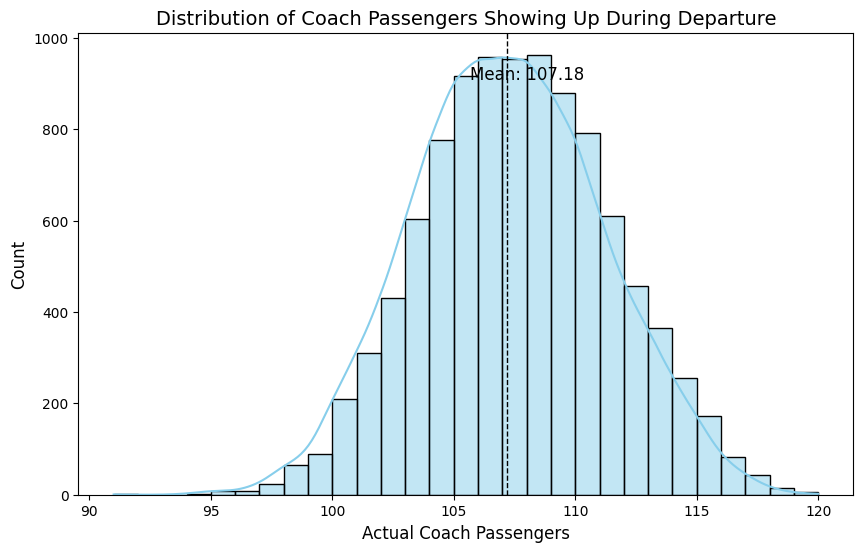

In [83]:
# Convert list to numpy array for calculations
tc_actual_data2 = np.array(tc_actual_list2)

plt.figure(figsize=(10, 6))
sns.histplot(tc_actual_data2, kde=True, color="skyblue", binwidth=1, binrange=(tc_actual_data2.min(), tc_actual_data2.max()))
plt.axvline(tc_actual_data2.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.87, max_ylim*0.9, f'Mean: {tc_actual_data2.mean():.2f}', fontsize=12)
plt.title('Distribution of Coach Passengers Showing Up During Departure', fontsize=14)
plt.xlabel('Actual Coach Passengers', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

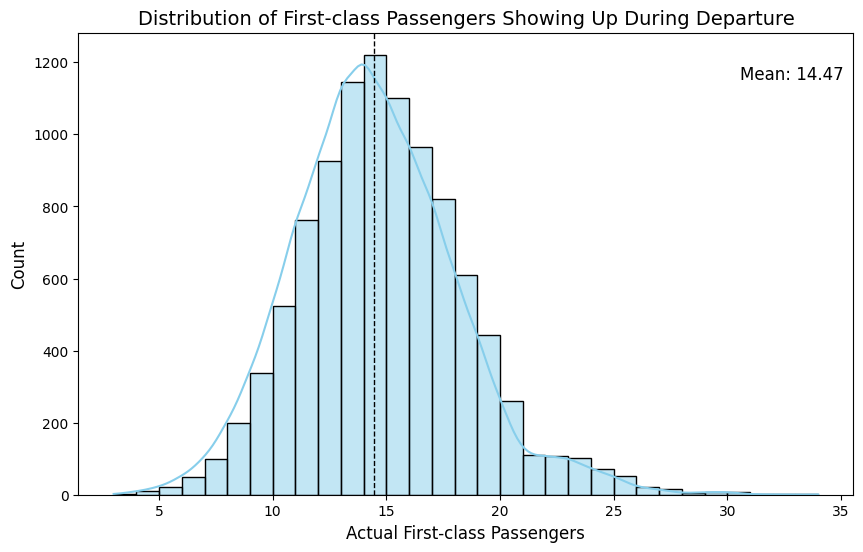

In [84]:
# Convert list to numpy array for calculations
tf_actualdata2 = np.array(tf_actual_list2)

plt.figure(figsize=(10, 6))
sns.histplot(tf_actualdata2, kde=True, color="skyblue", binwidth=1, binrange=(tf_actualdata2.min(), tf_actualdata2.max()))
plt.axvline(tf_actualdata2.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.86, max_ylim*0.9, f'Mean: {tf_actualdata2.mean():.2f}', fontsize=12)
plt.title('Distribution of First-class Passengers Showing Up During Departure', fontsize=14)
plt.xlabel('Actual First-class Passengers', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

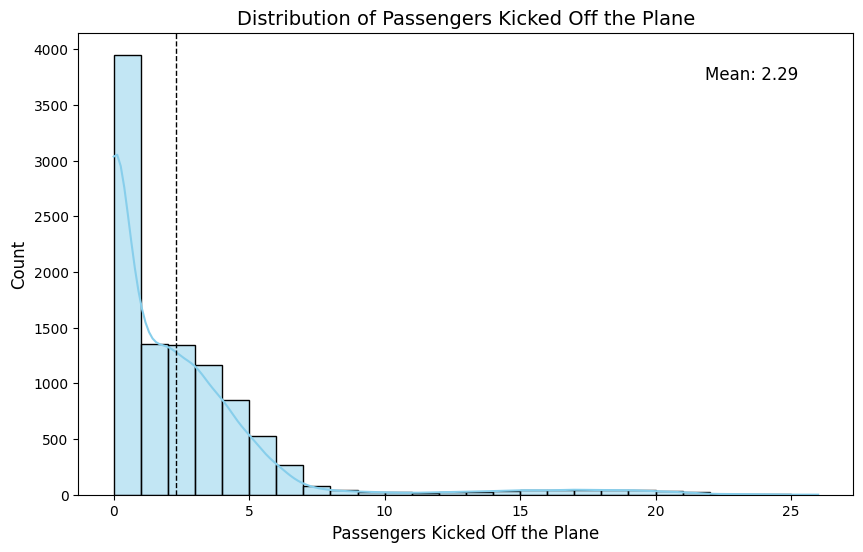

In [85]:
# Convert list to numpy array for calculations
data = np.array(count_out_list2)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color="skyblue", binwidth=1, binrange=(data.min(), data.max()))
plt.axvline(data.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.8, max_ylim*0.9, f'Mean: {data.mean():.2f}', fontsize=12)
plt.title('Distribution of Passengers Kicked Off the Plane', fontsize=14)
plt.xlabel('Passengers Kicked Off the Plane', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [86]:
no_passenger_kicked_count = count_out_list.count(0)
at_least_one_kicked_count = 10000 - count_out_list2.count(0)

message = (
    f"Out of 10000 trials, there were {no_passenger_kicked_count} instances where no passenger was removed from the plane. "
    f"Whereas the occasions where at least one passenger was removed amounts to {at_least_one_kicked_count}."
)

print(message)

Out of 10000 trials, there were 7778 instances where no passenger was removed from the plane. Whereas the occasions where at least one passenger was removed amounts to 6050.


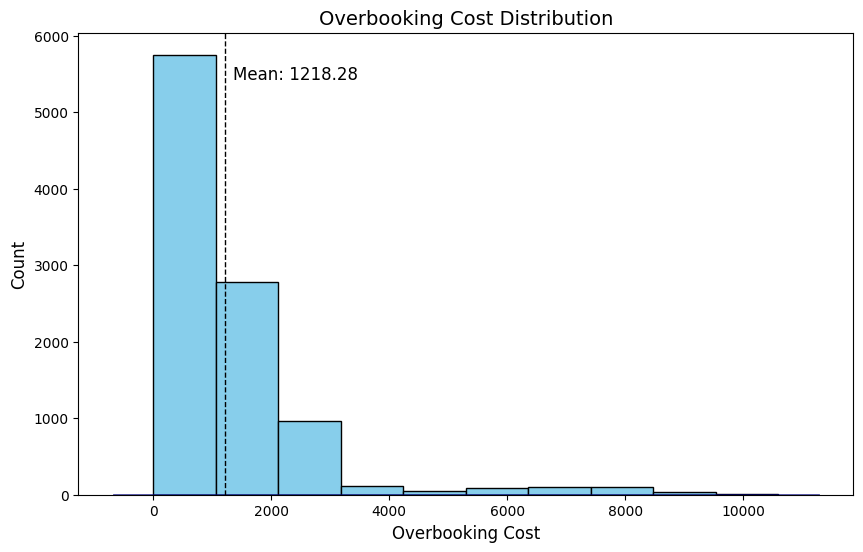

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


data = np.array(airline_cost_list2)

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram using matplotlib's hist function with sky blue color
plt.hist(data, color='skyblue', edgecolor='black')

# Overlay a density curve (kdeplot) with seaborn
sns.kdeplot(data, color="navy", linewidth=2, alpha=0.7)

# Draw a dashed vertical line at the mean
plt.axvline(data.mean(), color='k', linestyle='dashed', linewidth=1)

# Get the current limits of the plot for placing text and adjusting visuals
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()

# Place text annotation for the mean value, adjusting the position to be visible
plt.text(data.mean() + (max_xlim - min_xlim) * 0.01, max_ylim * 0.9, f'Mean: {data.mean():.2f}', fontsize=12)

# Set the title and labels with clear descriptions
plt.title('Overbooking Cost Distribution', fontsize=14)
plt.xlabel('Overbooking Cost', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

